In [1]:
%load_ext autoreload
%autoreload 2

In [93]:
import sys
sys.setrecursionlimit(8000)

import numpy as np
import os

import functions.utils as ut
from functions.graph import *

# Homework premises and preprocessing steps
## Data and setting
There are many options to collect and build the Wikipedia's underlying network, we rely on the dataset provided [here](https://snap.stanford.edu/data/wiki-topcats.html). For the purpose of our exploration, we do not consider the entire dataset. Instead, we focus on the articles belonging to a subset of categories. 


1.  Download the reduced version of the graph [Wikicat hyperlink graph](https://drive.google.com/file/d/1QVt0aMOFvLjOEm5eKeCxBQUwIU30_NIh/view?usp=sharing). Every row indicates an edge. In particular, the two elements are the source and the target, respectively.
2.  From [this](https://snap.stanford.edu/data/wiki-topcats.html) page download:
	-  `wiki-topcats-categories.txt.gz`: list of pages per category
	-  `wiki-topcats-page-names.txt.gz`: page names


Note that in the reduced version of the network we removed the categories whose number of articles in less than 5000 and more than 30000.

## General notes

1. You will notice that one article might belong to a single category or multiple ones. In the case of multiple appearance, you break the ties uniformly at random. Please, do it before solving any task in the homework.
2. We assume that all edges in the graphs we will consider have weight equal to 1.
2. __All the algorithms__, unless specified, must be implement from scratch.
3. The algorithms should handle exceptions, e.g. what if there is no path between two nodes?
4. Differently from other homeworks, we will execute your functions.


## Approach
In this phase, we break the ties uniformly at random for the categories of each link. That is, given a link, we want just one single category containing it. In order to do that, we iterate on the lines of the `wiki-topcats-categories.txt` file, where each category is mapped to the link it contains. We notice that this kind of mapping is not unique, meaning that multiple categories can contain the same link. Iterating on this file, we create a dictionary (`link_cat_dict`), which maps each link to the categories in which it appears, and its exact opposite, the one that stores the map between each category and the links it contains (`cat_link_dict`).

At this point, we just extract u.a.r. one single category for each link (`unique_link_cat_dict`), and we store also the opposite direction dictionary (`unique_cat_link_dict`). Once we're done, we create a new file (`wiki-topcats-categories-processed.txt`), which resembles the first one but for which each link is contained in just one category. And we're done!

## Observations
### Observation 1
Since there is some sort of randomness during the choice of the category, we give the possibility to use the pre-created preprocessed file. If one wants to run it from scratch and wants to create a new preprocessed file (containing the single category - link mapping), he just has to remove the pre existing processed file from the data directory.

### Observation 2
It's important to notice that, as it has been pointed out in the given notes, categories with an inappropriate size (with less than 5000 or more than 30000 nodes) have not been included in the `wikigraph_reduced.csv` file. For this particular reason, we thought that the best thing to do was to actually do the same when selecting the category for the links we're considering. Nevertheless, it can happen that some of this categories will retain a smaller amount of nodes (i.e., less than 5000), since some of the categories could overlap.

Anyway, once the preprocessing steps are done, we end up with a set of 21 categories.

In [3]:
preprocessed_path = 'data/wiki-topcats-categories-processed.txt'

if os.path.isfile(preprocessed_path):
    # If the preprocessed file already exist, read from it the dictionaries
    unique_link_cat_dict = ut.read_link_cat()
    unique_cat_link_dict = ut.read_cat_link()
else:
    # Otherwise, create them:
    # Dictionary containing links as keys and categories (multiple) and inverse
    link_cat_dict = ut.link_cat()
    cat_link_dict = ut.cat_link()
    # Dictionary containing links as keys and categories (unique-random) as values
    unique_link_cat_dict = ut.unique_link_cat(link_cat_dict, cat_link_dict)

    # Dictionary containing categories as keys and links as values
    unique_cat_link_dict = ut.unique_cat_link(unique_link_cat_dict)

    # Save preprocessed file for future use
    ut.write_category_processed(unique_cat_link_dict)

# RQ1
## Task
Build the graph G=(V, E), where *V* is the set of articles and *E* the hyperlinks among them. Then, provide its basic information:
 
- Is the graph directed?
- How many articles are we considering?
- How many hyperlinks between pages exist?
- Compute the average number of links in an arbitrary page. What is the graph [density](https://en.wikipedia.org/wiki/Dense_graph)? Do you believe that the graph is dense or sparse? Is the graph dense?
- Visualize the nodes' degree distribution

## Solution
### Creation of the graph
Let's first build the graph, by initializating it and then by manually adding each of the edge from the csv file to it. We decided to create our graph data structure from scratch, but we obviously took inspiration from the networkx implementation. Our graph is basically a dictionary, for which the keys are the nodes and the values are the out-neighbours of each edge. The function `add_edge` adds a new key to the dictionary if that doesn't exist, otherwise adds the input edge to the already existing key. The graph edges will look something like this:

```python
{
    1: {3, 4, 5},
    2: {3, 6},
    3: {1, 4, 5},
    ...
}
```
More details are obviously given in the code.

To add the edge, we just have to iterate on the `wikigraph_reduced.csv`, for which each line represent src $\to$ dst edge.

In [4]:
path = 'data/wikigraph_reduced.csv'

graph = Graph()

with open(path) as f:
    for i, line in enumerate(f):
        if i == 0:
            continue
        line = line.strip().split()
        line = [int(el) for el in line]
        _, src, dst = line
        graph.add_edge(src, dst)

### Graph info
We implemented some basic functions for our graph. First of all, we can retrieve the number of nodes and number of edges by just calling their respective function (`number_of_nodes()` and `number_of_edges()`). Then, to check if the graph is directed we went through the edges of the graph. For each pair (src, dst), we search for an inverted edge, in the form (dst, src). If it exists one edge that isn't invertible, then we can counclude that the graph is directed; otherwise, we can assume that it is not directed (`is_directed()` function).

To compute the graph density, we used the following formula:
\begin{equation*}
D = \begin{cases}
\frac{2|E|}{|V|(|V| - 1)}  &\text{if the graph is undirected}\\
\frac{|E|}{|V|(|V| - 1)} &\text{if the graph is directed}
\end{cases}
\end{equation*}
where $|E|$ and $|V|$ respectively represent the number of edges and of nodes of the graph.

#### Observation about sparsity
The density of a graph is a value between 0 and 1. In our case, the density we obtain from our graph is much closer to zero, meaning we can safely assume that the graph is sparse. In fact, we can also observe that there is actually a really small number of hyperlinks for each node.

In [4]:
n_nodes = graph.number_of_nodes()
n_edges = graph.number_of_edges()

if graph.is_directed():
    print('The graph is directed.')
else:
    print('The graph is not directed.')

# Number of articles corresponds to number of nodes src that have an edge src -> dst
print('Number of articles: {}'.format(n_nodes))
# Number of hyperlinks corresponds to number of edges
print('Number of hyperlinks: {}'.format(n_edges))

print('Average number of hyperlinks: {:.1f}'.format(n_edges / n_nodes))
print('Graph density: {:.10f}'.format(graph.density()))

The graph is directed.
Number of articles: 98343
Number of hyperlinks: 483094
Average number of hyperlinks: 4.9
Graph density: 0.0000499516


### Degree distribution
For the degree distribution, we decided to use a logarithmic scale plot, since it's just much more convenient and easier to understand what's going on.

We can see that most of the nodes have a really low degree, while the vast majority of them retain a low degree. This enforces our affermation on the sparsity of the graph.

**Notice** that our graph data structure stores both the in-degree and the out-degree. For this particular exercise, we used the total degree for the plot.

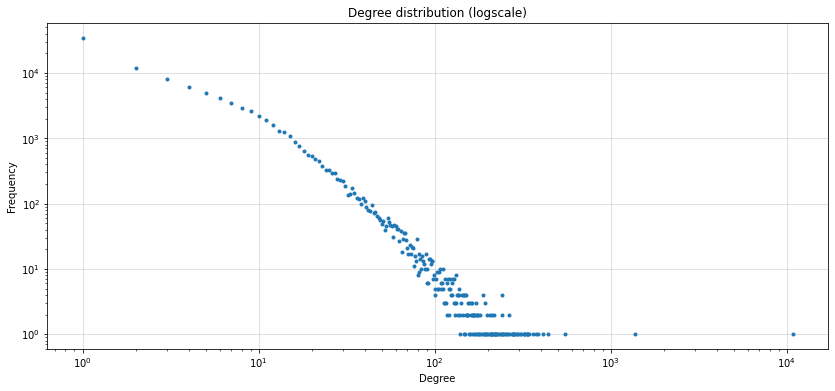

In [5]:
graph.degree_distribution_plot()

# RQ2
## Task
Define a function that takes in input:
- A page _v_
- A number of clicks _d_

and returns the set of all pages that a user can reach within _d_ clicks. 

## Solution
Reading the code for this function (`pages_within_clicks`), the solution we proposed should be pretty straightforward. Basically, we search on the out-neighbours of a given node and store them. Once we've finished this search (which would represent the first iteration/click), we search on the out-neighbours on each and every node we've found from the first iteration, and so on so forth, we continue for the number of clicks given in input.

Obviously, increasing the number of clicks, dramatically increases the number of reachable nodes. This value increases until there is a plateu, which happens to exist since, at some point, because we encounter a graph connected component. For the example below, we see that this happens once we hit 15 clicks.

In [7]:
starting_node = 786432
n_clicks = 2

print('Nodes reachable in {} clicks starting from the node {}:'.format(n_clicks, starting_node))
print(graph.pages_within_clicks(starting_node, n_clicks))

print('')


reach_table = []
for n_clicks in range(1, 21):
    reachable = graph.pages_within_clicks(starting_node, n_clicks)
    reach_table.append(('Reachable nodes in {} clicks'.format(n_clicks), len(reachable)))

title = 'Starting from node {}'.format(starting_node)
ut.generate_table(reach_table, title=title, reverse=False)

Nodes reachable in 2 clicks starting from the node 786432:
{786432, 786433, 999877, 786381, 786382, 786383, 786384, 786385, 786386, 786387, 1622420, 786388, 787539, 787290, 783579, 787486, 787552, 1622647, 1622313, 785517, 787374, 787822, 787377, 1622321, 786295, 786424, 785340, 1000831}

      Starting from node 786432       
--------------------------------------
Reachable nodes in 1 clicks     | 3                              
Reachable nodes in 2 clicks     | 28                             
Reachable nodes in 3 clicks     | 178                            
Reachable nodes in 4 clicks     | 439                            
Reachable nodes in 5 clicks     | 1085                           
Reachable nodes in 6 clicks     | 2235                           
Reachable nodes in 7 clicks     | 3885                           
Reachable nodes in 8 clicks     | 5497                           
Reachable nodes in 9 clicks     | 6342                           
Reachable nodes in 10 clicks    | 6549

# RQ3
## Task
Define a function that takes in input:

- A category _C_
- A set of pages in _C_, _p = {p<sub>1</sub>, ..., p<sub>n</sub>}_

and returns the minimum number of clicks required to reach all pages in _p_, starting from the page _v_, corresponding to the most central article, according to the _in-degree_ centrality, in _C_.

Consider that:
- The algorithm needs to handle the case that the graph is not connected, thus not all the pages in _p_ are reachable from _v_. In such scenario, it is enough to let the program give in output the string "Not possible".
- Since we are dealing with graph exploration, you can pass more than once on the same page _p<sub>i</sub>_.
- Since the problem’s complexity is high, consider to provide just an approximation/heuristic solution for the problem. 
- You can use whatever metrics of centrality.

## Solution
Before actually going into the solution itself, it is important to make some remarks. First of all, we decided to use the in-degree for the centrality metric. Then, we didn't feel like an heuristic solution was needed: working with a very sparse graph, we noticed that there weren't really great problems exploring a complete category. That being said, to the algorithm we go.

The solution we proposes is encapsulated in two main functions: `min_clicks`, which actually gives the answer to the question, and `shortest_path`, which, in this particular case, serves as an helper function. In fact, to compute the minimum number of clicks needed to reach all pages in a set $p$, starting from a single node in another category (the most central one), what we need to do is the following:

- Compute the most central node in the given category;
- Compute the shortest path between this node and all the nodes in the given set;
- Return the maximum lenght of these distances.

There are a few details it's worth to display:

1. We based our computation of the shortest on the BFS algorithm;
2. There are some basic cases in which we automatically give the response "Not possible", e.g. when the input nodes are not contained in the graph itself, when the input nodes in the set are not into the input category, and finally when there is no actual path between even one single pair (central_node, n), for n in the given category.

In [8]:
# Example

category = 'English-language_films'
most_central_node = graph.most_central_article(category)

pages = {556939, 601747, 930430, 1041649, 1266258}

min_clicks = graph.min_clicks(category, pages)


print(
    f'Category: {category}\n'
    f'Most central article: {most_central_node}\n'
    f'Pages: {pages}\n'
    f'Minimum number of clicks: {min_clicks}'
)

Category: English-language_films
Most central article: 1063315
Pages: {556939, 1041649, 1266258, 601747, 930430}
Minimum number of clicks: 5


# RQ4
## Task
Given in input two categories: C<sub>1</sub> and C<sub>2</sub>, we get the subgraph induced by all the articles in the two categories. 

- Let _v_ and _u_ two arbitrary pages in the subgraph. What is the minimum set of hyperlinks one can remove to disconnect _u_ and _v_?

## Solution
### Example
Before we move to the actual solution of the research question, so working with the subgraph induced by two categories, let's visualize its rationale with an easy example. This can be useful also because it's not that easy to find a meaningful example extracting two categories-subgraphs.

Let `g` be a directed graph, defined by its edges:

(1 $\to$ 2), 
(1 $\to$ 3), 
(1 $\to$ 6), 
(1 $\to$ 7), 
(2 $\to$ 4), 
(3 $\to$ 4), 
(6 $\to$ 8), 
(7 $\to$ 8), 
(4 $\to$ 5), 
(8 $\to$ 5), 
(1 $\to$ 5)

Let's use `networkxx` to visualize this graph.

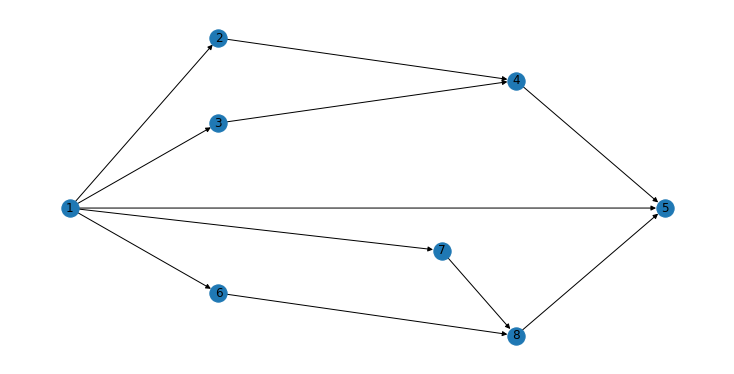

In [9]:
ut.graph_example()

Let's say we want to disconnect nodes **1** and **5**. It should be pretty straightforward that the minimum number of edges we need to remove from the graph in order to disconnect the two nodes are:

(1 $\to$ 5), (4 $\to$ 5), (8 $\to$ 5).

These can be simply obtained by looking at the disjoint paths between 1 and 5, so to actually know the number of edges we need to remove from the graph to disconnect two nodes we just need to see how many disjoint paths connect them.

Now we can create the graph, add the edges and see if this works! The solution for this kind of problem is contained in the `DisjointPaths`, which is a modified version of the DFS, exploring a graph in the exact opposite way a BFS would go. Inside this class there are two functions: `dfs`, which actually goes in depth in the graph searching for disjoint paths, traversing in depth from a source node to a destination one, and marking the followed path (marking the edges). There is then the `search` function, which is used to retrieve **all** the disjoint paths, by starting over from the source node everytime it succedes in finding a path.

In [92]:
g = Graph()

edges = [
    (1, 2),
    (1, 3),
    (1, 6),
    (1, 7),
    (2, 4),
    (3, 4),
    (6, 8),
    (7, 8),
    (4, 5),
    (8, 5),
    (1, 5),
]

g.add_edges_from(edges)

src = 1
dst = 5
d = DisjointPaths(g)
d.search(src, dst)
disjoint_paths = d.paths[(src, dst)]
print(f'Disjoint paths between {src} and {dst}: {disjoint_paths}.')

print('The minimum set of hyperlinks to remove from the graph to disconnect node 1 and 5 is {}.'.format(min_edge_cut(g, 1, 5)))

Disjoint paths between 1 and 5: [[1, 2, 4, 5], [1, 5], [1, 6, 8, 5]].
The minimum set of hyperlinks to remove from the graph to disconnect node 1 and 5 is 3.


### Application on the subgraph
Let's select now two populated categories. The function `categories_size` should help us for this task, since it is going to print the number of nodes contained in the graph belonging to each category. We are then going to select two categories that, somehow, seem to be related.

In [11]:
categories_sizes = ut.categories_size(graph)

ut.generate_table(categories_sizes, title='Categories Sizes', amount='all')

                               Categories Sizes                               
------------------------------------------------------------------------------
English-language_films                                                 | 13209                                                                 
American_film_actors                                                   | 9063                                                                  
Main_Belt_asteroids                                                    | 8643                                                                  
Rivers_of_Romania                                                      | 7662                                                                  
American_films                                                         | 7639                                                                  
American_television_actors                                             | 6520                                             

The subgraph induced by category 1 and category 2 is going to be made as follows: first of all, we filter out all the nodes that don't belong to neither categories. Then, we select the edges that are in the form (src, dst), where both `src` and `dst` are either in category 1 or category 2.

In [94]:
category1 = 'The_Football_League_players'
category2 = 'English_footballers'

subgraph = induced_subgraph(graph, category1, category2)

In [110]:
src = 81920
dst = 83460

print('The minimum set of hyperlinks to remove from the subgraph to disconnect node 81928 and 82068 is {}.'.format(min_edge_cut(subgraph, 81920, 83460)))

The minimum set of hyperlinks to remove from the subgraph to disconnect node 81928 and 82068 is 4.


# RQ5
## Task
Write a function that, given an arbitrary category C<sub>0</sub> as input, returns the list of remaning categories sorted by their distance from C<sub>0</sub>. In particular, the distance between two categories is defined as 

distance(C<sub>0</sub>, C<sub>i</sub>) = median(ShortestPath(C<sub>0</sub>, C<sub>i</sub>))

where ShortestPath(C<sub>0</sub>, C<sub>i</sub>) is the set of shortest paths from each pair of nodes in the two categories.

## Solution
The functions used to compute the distance between one category and all the others are `get_distances`, in the `Graph` class, and `ordered_distances`. The first method is a modified version of the BFS algorithm, used to explore the graph starting from a root node. Along with the nodes reachable from the root, this function also retrieves the distances between the root and all the nodes it encounters. This speeds up the computation a lot, since, in order to compute the distance between one selected category and all the others, it is sufficient to iterate on the nodes of the selected category and apply this modified BFS method.

That's exactly the purpose of the `ordered_distances` function, which iterates on the nodes of the selected category, stores the distances from all the nodes of the category to all the other nodes, and then assigns these distances in a dictionary. More details are given in the docs of the function.

To prove the efficiency of the described function, we tried it on a pretty big category: "American_television_actors". We can see from the previous table that this category contains 9063 nodes, so... keep tight, because it's going to take some time to run the following operations (about 10 mins).

In [74]:
c1 = 'American_television_actors'

ordered_categories = ordered_distances(graph, c1, unique_link_cat_dict)

title = "Category distance from '{}'".format(c1)
ut.generate_table(ordered_categories, title=title, reverse=False)

            Category distance from 'American_television_actors'             
----------------------------------------------------------------------------
American_film_actors                                                   | 5.0                                                                   
English-language_films                                                 | 5.0                                                                   
American_films                                                         | 5.0                                                                   
Place_of_birth_missing_(living_people)                                 | 5.0                                                                   
Black-and-white_films                                                  | 5.0                                                                   
Debut_albums                                                           | 6.0                                                  

# RQ6
## Task
Write a function that sorts the categories in the graph according to their PageRank (PR). For this task you need to model the network of categories such that you can apply the PR algorithm.

## Solution
### Category graph
Before diving straight into the solution, some details about the approach we've taken is mandatory. First of all, we didn't work on the initial graph itself. In fact, we tought it could be much more convenient to work with another version of it, where each node is replaced by the category where it belongs. In our opinion, this makes much more sense, since we have to give a score to the categories. 

For example, if our graph is composed by the following edges:

(1 $\to$ 2), 
(1 $\to$ 3), 
(1 $\to$ 7), 
(2 $\to$ 4), 
(3 $\to$ 4), 
(6 $\to$ 8), 
(7 $\to$ 8).

and we have three categories:
```python
category_1 = {2, 3}
category_2 = {1, 4, 6, 8}
category_3 = {5, 7}
```
the new graph would be: 

(category_2 $\to$ category_1), 
(category_2 $\to$ category_3), 
(category_1 $\to$ category_2), 
(category_2 $\to$ category_2), 
(category_3 $\to$ category_2).

Obviously, some of the edges get removed this way, since there could be two edges that, once translated, would be the exact same thing. We think this is an ok option, nevertheless there is still some room to improve. For example, one could increase the weight of an edge if that particular edge gets repeated. We didn't have time neither to think or to implement this option, but if we had more time we probably would have.

### PageRank
For the implementation of the PageRank, we mainly followed 3 sources:
- The original paper from Sergey Brin and Lawrence Page, where they present Google and PageRank: [The Anatomy of a Large-Scale Hypertextual Web Search Engine](http://infolab.stanford.edu/pub/papers/google.pdf);
- The [PageRank Wikipedia page](https://en.wikipedia.org/wiki/PageRank), where the algorithm is well described and some toughts on the choice of the damping factor/implementation are presented;
- The [source code](https://networkx.org/documentation/networkx-1.10/_modules/networkx/algorithms/link_analysis/pagerank_alg.html#pagerank) for PageRank by NetworkX, from which we took the idea for our implementation, studied the details and tried to come up with a similar/efficient solution that worked on the graph data structure we created from scratch. We obviously made some changes, both caused by the different data structure and both because of how we tought was the best/clear way to implement the algorithm, but we compared the results and saw that they produces identical results.

In [15]:
# Create the graph composed by the categories nodes starting from the main graph
cat_graph = create_category_graph(graph, unique_link_cat_dict)

# Compute and print the pagerank
PR = pagerank(cat_graph)
PR_table = dict_to_table(graph, PR)
ut.generate_table(PR_table, title='Category PageRank')

                                      Category PageRank                                      
---------------------------------------------------------------------------------------------
English-language_films                                                 | 0.07066980197129523                                                   
Year_of_death_missing                                                  | 0.05443541978298677                                                   
Place_of_birth_missing_(living_people)                                 | 0.05443541978298677                                                   
American_television_actors                                             | 0.05443541978298677                                                   
American_film_actors                                                   | 0.05443541978298677                                                   
Harvard_University_alumni                                              | 0.05220467802595087